## Cargar los datos

In [ ]:
import numpy as np
import pandas as pd
#----------------------------------------------------------
# Url de los datos
#----------------------------------------------------------

url= ("https://raw.githubusercontent.com/MavelSterling/proyecto_AMN/main/city_temp.csv")

#----------------------------------------------------------
# Se cargan los datos
#----------------------------------------------------------
datos = pd.read_csv(url, sep=";")
datos

,Region,Month,Day,AvgTemperature
0,Africa,1,1,64.2
1,Africa,1,2,49.4
2,Africa,1,3,48.8
3,Africa,1,4,46.4
4,Africa,1,5,47.9
...,...,...,...,...
1048570,Middle East,2,7,-99.0
1048571,Middle East,2,8,-99.0
1048572,Middle East,2,9,-99.0
1048573,Middle East,2,10,-99.0


# Análisis descriptivo de los datos

In [ ]:
# Filtrar las filas con temperatura promedio mayor o igual a -2.86
datos_seleccionados = datos[datos['AvgTemperature'] >= -2.86]

# Puedes imprimir las filas seleccionadas o realizar otras operaciones con ellas
print(datos_seleccionados)

              Region  Month  Day  AvgTemperature
0             Africa      1    1            64.2
1             Africa      1    2            49.4
2             Africa      1    3            48.8
3             Africa      1    4            46.4
4             Africa      1    5            47.9
...              ...    ...  ...             ...
1047071  Middle East      5   13            67.8
1047180  Middle East      4   19            82.8
1047338  Middle East      9   24            94.5
1047339  Middle East      9   25            92.6
1047345  Middle East     10    1            93.1

[990083 rows x 4 columns]


In [ ]:
datos_seleccionados = pd.DataFrame(datos_seleccionados)
datos_seleccionados

,Region,Month,Day,AvgTemperature
0,Africa,1,1,64.2
1,Africa,1,2,49.4
2,Africa,1,3,48.8
3,Africa,1,4,46.4
4,Africa,1,5,47.9
...,...,...,...,...
1047071,Middle East,5,13,67.8
1047180,Middle East,4,19,82.8
1047338,Middle East,9,24,94.5
1047339,Middle East,9,25,92.6


## Información de la BD

In [ ]:

#----------------------------------------------------------
# Información de la base de datos
#----------------------------------------------------------

datos_seleccionados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 990083 entries, 0 to 1047345
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Region          990083 non-null  object 
 1   Month           990083 non-null  int64  
 2   Day             990083 non-null  int64  
 3   AvgTemperature  990083 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 37.8+ MB


## Resumen de las variables - cuantitativas

In [ ]:
#----------------------------------------------------------
# Resumen de los datos
#----------------------------------------------------------
datos_seleccionados.describe()

,Month,Day,AvgTemperature
count,990083.000000,990083.000000,990083.000000
mean,6.464613,15.710191,63.569135
std,3.449574,8.800736,17.757358
min,1.000000,1.000000,-2.800000
25%,3.000000,8.000000,51.700000
50%,6.000000,16.000000,66.100000
75%,9.000000,23.000000,78.700000
max,12.000000,31.000000,110.000000


## Resumen de la variable cualitativa

In [ ]:
datos_seleccionados.select_dtypes(include=['object']).describe()


,Region
count,990083
unique,5
top,Europe
freq,368484


## Correlación de las variables día, mes y temperatura

In [ ]:
datos_seleccionados.iloc[:,1:4]

correlacion= datos_seleccionados.iloc[:,1:4].corr(method ='pearson')



<Axes: >

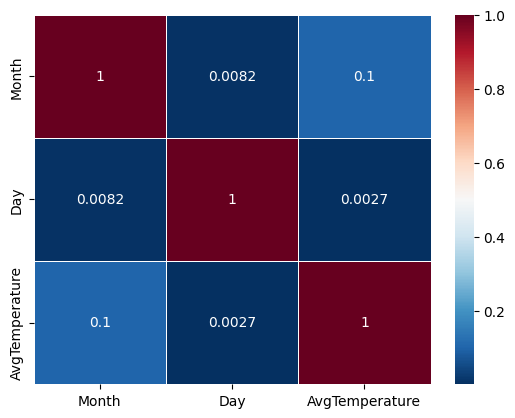

In [ ]:
import seaborn as sb

sb.heatmap(correlacion,
            xticklabels=correlacion.columns,
            yticklabels=correlacion.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)


# Modelo de red neuronal

## Dividir los datos de entrenamiento y de prueba

In [ ]:
#----------------------------------------------------------
# Datos de entrenamiento y de prueba
#----------------------------------------------------------
import random

# Obtener el número total de filas en el DataFrame
num_rows = len(datos_seleccionados)

# Calcular el número de filas a seleccionar (80%)
num_train = int(0.8 * num_rows)

# Generar índices aleatorios únicos para la selección
random_indices = random.sample(range(num_rows), num_train)

# Crear un conjunto de índices válidos
valid_indices = set(random_indices)

# Obtener los datos de entrenamiento y prueba
train_data = datos_seleccionados.iloc[random_indices]
test_data = datos_seleccionados.drop(datos_seleccionados.index.difference(valid_indices))

print("Total de datos de la BD:",len(datos_seleccionados), "|","80% de los datos:", len(train_data), "|", "20% de los datos:", len(test_data))

Total de datos de la BD: 990083 | 80% de los datos: 792066 | 20% de los datos: 746954


990083 es el número de observaciones en la base de datos

792066 es el 80% de las observaciones de la base de datos que se van a utilizar para entrenar los datos

746839 es el 20% de las observaciones de la base de datos que se van a utilizar para probar el modelo de predicción

## Dimenciones de los datos de entrenamiento

In [ ]:
#----------------------------------------------------------
# Dimensiones de los datos de entrenamiento
#----------------------------------------------------------
train_data.shape

(792066, 4)

In [ ]:
#----------------------------------------------------------
# Mostrar 5 filas de los datos de entrenamiento
#----------------------------------------------------------

train_data.head(5)

,Region,Month,Day,AvgTemperature
814701,Europe,8,12,64.3
954798,Europe,10,6,56.4
309787,Asia,11,17,67.5
345304,Asia,8,23,85.6
46094,Africa,4,16,72.4


## Función de activación, función de costo y gradiente

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np
import time

# Función de activación sigmoide
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Función de costo (error cuadrático medio)
def cost_function(a, b, x_day, x_month, y_actual):
    start_time = time.time()
    y_pred = sigmoid(a * x_day + b * x_month)
    error = np.mean((y_pred - y_actual) ** 2)
    end_time = time.time()
    print("Tiempo de ejecución de cost_function:", end_time - start_time)
    return error

# Gradiente de la función de costo
def gradient(a, b, x_day, x_month, y_actual):
    start_time = time.time()
    n = len(x_day)
    gradient_a = (2/n) * np.sum((a*x_day + b*x_month - y_actual) * x_day * sigmoid(a*x_day + b*x_month) * (1 - sigmoid(a*x_day + b*x_month)))
    gradient_b = (2/n) * np.sum((a*x_day + b*x_month - y_actual) * x_month * sigmoid(a*x_day + b*x_month) * (1 - sigmoid(a*x_day + b*x_month)))
    end_time = time.time()
    print("Tiempo de ejecución de gradient:", end_time - start_time)
    return gradient_a, gradient_b

# Descenso de gradiente
def gradient_descent(x_day, x_month, y_actual, learning_rate, num_iterations):
    start_time = time.time()
    a = random.uniform(-1, 1)  # Inicialización aleatoria de a
    b = random.uniform(-1, 1)  # Inicialización aleatoria de b
    errors = []

    for _ in range(num_iterations):
        error = cost_function(a, b, x_day, x_month, y_actual)
        gradient_a, gradient_b = gradient(a, b, x_day, x_month, y_actual)
        a -= learning_rate * gradient_a
        b -= learning_rate * gradient_b
        errors.append(error)

    end_time = time.time()
    print("Tiempo de ejecución de gradient_descent:", end_time - start_time)
    return a, b, errors

## Datos de entrenamiento

In [ ]:

# Datos de entrenamiento
x_day = np.array(train_data.Day)  # Días
x_month = np.array(train_data.Month)  # Mes
y_actual = np.array(train_data.AvgTemperature)  # Temperaturas reales

learning_rate = 0.01
num_iterations = 1000

print("Datos de entrenamiento del Día", x_day)
print("Datos de entrenamiento del Mes", x_month)
print("Datos de entrenamiento de la Temperatura", y_actual)



Datos de entrenamiento del Día [12  6 17 ... 10 15 21]
Datos de entrenamiento del Mes [ 8 10 11 ...  4  5  4]
Datos de entrenamiento de la Temperatura [64.3 56.4 67.5 ... 32.4 83.1 45.8]


## Se entrena el modelo

In [ ]:
# Entrenamiento del modelo
start_time = time.time()
a_pred, b_pred, errors = gradient_descent(x_day, x_month, y_actual, learning_rate, num_iterations)
end_time = time.time()
print("Tiempo total de ejecución:", end_time - start_time)

Tiempo de ejecución de cost_function: 0.11230993270874023
Tiempo de ejecución de gradient: 0.259768009185791
Tiempo de ejecución de cost_function: 0.042536020278930664
Tiempo de ejecución de gradient: 0.15340757369995117
Tiempo de ejecución de cost_function: 0.06315064430236816
Tiempo de ejecución de gradient: 0.17025256156921387
Tiempo de ejecución de cost_function: 0.0544435977935791
Tiempo de ejecución de gradient: 0.26395082473754883
Tiempo de ejecución de cost_function: 0.03478884696960449
Tiempo de ejecución de gradient: 0.2794501781463623
Tiempo de ejecución de cost_function: 0.10506749153137207
Tiempo de ejecución de gradient: 0.3602883815765381
Tiempo de ejecución de cost_function: 0.13458490371704102
Tiempo de ejecución de gradient: 0.34084177017211914
Tiempo de ejecución de cost_function: 0.06260371208190918
Tiempo de ejecución de gradient: 0.4052877426147461
Tiempo de ejecución de cost_function: 0.09737491607666016
Tiempo de ejecución de gradient: 0.38858819007873535
Tiempo

## Predicción del modelo

In [191]:
# Predicción
#day = 6
#month = 6
day = np.array(test_data.Day)
month = np.array(test_data.Month)
predicted_temperature = sigmoid(a_pred * day + b_pred * month)
max_temp= max(test_data.AvgTemperature)
min_temp = min(test_data.AvgTemperature)
predicted_temperature = predicted_temperature * (max_temp - min_temp) + min_temp



print("La temperatura predicha para el día", day, "y mes", month, "es:", predicted_temperature)
print( )
print("La temperatura: ", predicted_temperature)



La temperatura predicha para el día [ 1  2  5 ... 20 21 22] y mes [ 1  1  1 ... 11 11 11] es: [ 98.28287724 102.31665499 103.58376076 ... 103.6        103.6
 103.6       ]

La temperatura:  [ 98.28287724 102.31665499 103.58376076 ... 103.6        103.6
 103.6       ]


## Gráfica del valor de a, b y el error

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Tiempo de ejecución de cost_function: 0.014119386672973633
Tiempo de ejecución de cost_function: 0.01736593246459961
Tiempo de ejecución de cost_function: 0.015134096145629883
Tiempo de ejecución de cost_function: 0.013035297393798828
Tiempo de ejecución de cost_function: 0.017682552337646484
Tiempo de ejecución de cost_function: 0.012539863586425781
Tiempo de ejecución de cost_function: 0.01317143440246582
Tiempo de ejecución de cost_function: 0.013239383697509766
Tiempo de ejecución de cost_function: 0.013125419616699219
Tiempo de ejecución de cost_function: 0.012732744216918945
Tiempo de ejecución de cost_function: 0.012775182723999023
Tiempo de ejecución de cost_function: 0.014281511306762695
Tiempo de ejecución de cost_function: 0.013235092163085938
Tiempo de ejecución de cost_function: 0.013269901275634766
Tiempo de ejecución de cost_function: 0.013282537460327148
Tiempo de ejecución de cost_function: 0.0131640434

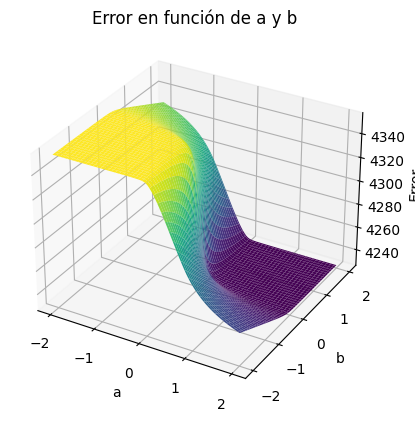

In [192]:
# Graficar el valor de a, b y el error
a_vals = np.linspace(-2, 2, 100)
b_vals = np.linspace(-2, 2, 100)
A, B = np.meshgrid(a_vals, b_vals)
errors_mesh = np.zeros_like(A)

for i in range(len(a_vals)):
    for j in range(len(b_vals)):
        errors_mesh[i, j] = cost_function(A[i, j], B[i, j], x_day, x_month, y_actual)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(A, B, errors_mesh, cmap='viridis')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('Error')
ax.set_title('Error en función de a y b')
plt.show()

*texto en cursiva*# Sección nueva

## Gráfica

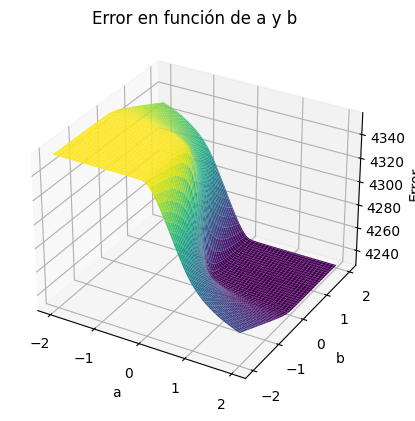

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(A, B, errors_mesh, cmap='viridis')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('Error')
ax.set_title('Error en función de a y b')
plt.show()


# Modelo de red neuronal con la región

## Codificar variable región

In [ ]:
# Contar la frecuencia de la variable
frecuencia = datos_seleccionados['Region'].value_counts()

# Mostrar los resultados
print(frecuencia)

Europe                     368484
Asia                       304374
Africa                     220919
Australia/South Pacific     55209
Middle East                 41097
Name: Region, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Crear un objeto LabelEncoder
label_encoder = LabelEncoder()

# Codificar la variable "region" a numérica
datos_seleccionados['region_codificada'] = label_encoder.fit_transform(datos_seleccionados['Region'])

# Mostrar los resultados
print(datos_seleccionados)

              Region  Month  Day  AvgTemperature  region_codificada
0             Africa      1    1            64.2                  0
1             Africa      1    2            49.4                  0
2             Africa      1    3            48.8                  0
3             Africa      1    4            46.4                  0
4             Africa      1    5            47.9                  0
...              ...    ...  ...             ...                ...
1047071  Middle East      5   13            67.8                  4
1047180  Middle East      4   19            82.8                  4
1047338  Middle East      9   24            94.5                  4
1047339  Middle East      9   25            92.6                  4
1047345  Middle East     10    1            93.1                  4

[990083 rows x 5 columns]


In [ ]:
# Contar la frecuencia de la variable
frecuencia_region_cod = datos_seleccionados['region_codificada'].value_counts()

# Mostrar los resultados
print(frecuencia_region_cod)

3    368484
1    304374
0    220919
2     55209
4     41097
Name: region_codificada, dtype: int64


In [ ]:
datos_region = datos_seleccionados.iloc[:, 1:5]
datos_region

,Month,Day,AvgTemperature,region_codificada
0,1,1,64.2,0
1,1,2,49.4,0
2,1,3,48.8,0
3,1,4,46.4,0
4,1,5,47.9,0
...,...,...,...,...
1047071,5,13,67.8,4
1047180,4,19,82.8,4
1047338,9,24,94.5,4
1047339,9,25,92.6,4


In [ ]:
datos_seleccionados.region_codificada.describe()

count    990083.000000
mean          1.701506
std           1.284158
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max           4.000000
Name: region_codificada, dtype: float64

In [ ]:
datos_seleccionados.describe()

,Month,Day,AvgTemperature,region_codificada
count,990083.000000,990083.000000,990083.000000,990083.000000
mean,6.464613,15.710191,63.569135,1.701506
std,3.449574,8.800736,17.757358,1.284158
min,1.000000,1.000000,-2.800000,0.000000
25%,3.000000,8.000000,51.700000,1.000000
50%,6.000000,16.000000,66.100000,1.000000
75%,9.000000,23.000000,78.700000,3.000000
max,12.000000,31.000000,110.000000,4.000000


## Dividir los datos de entrenamiento y de prueba

In [ ]:
#----------------------------------------------------------
# Datos de entrenamiento y de prueba
#----------------------------------------------------------
import random

# Obtener el número total de filas en el DataFrame
num_rows_region = len(datos_region)

# Calcular el número de filas a seleccionar (80%)
num_train_region = int(0.8 * num_rows_region)

# Generar índices aleatorios para la selección
random_indices_region = random.sample(range(num_rows_region), num_train_region)

# Obtener los datos de entrenamiento y prueba
train_data_region = datos_region.iloc[random_indices_region]
test_data_region = datos_region.drop(datos_region.index.difference(valid_indices))
print("80% de los datos para entrenar el modelo:",len(train_data_region),"\n", "20% de los datos para prueba del modelo:",len(test_data_region))

80% de los datos para entrenar el modelo: 792066 
 20% de los datos para prueba del modelo: 746994


## Dimenciones de los datos de entrenamiento

In [ ]:
#----------------------------------------------------------
# Dimensiones de los datos de entrenamiento
#----------------------------------------------------------
train_data_region.shape

(792066, 4)

In [ ]:
#----------------------------------------------------------
# Mostrar 5 filas de los datos de entrenamiento
#----------------------------------------------------------

train_data_region.head(5)

,Month,Day,AvgTemperature,region_codificada
92489,5,22,85.3,0
181716,9,16,79.0,0
83956,5,26,85.8,0
834256,6,1,57.2,3
69341,2,14,82.2,0


## Función de activación, función de costo y gradiente

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np
import time

# Función de activación sigmoide
def sigmoid_region(x):
    return 1 / (1 + np.exp(-x))

# Función de costo (error cuadrático medio)
def cost_function_region(a, b, c, x_day, x_month, x_region, y_actual):
    start_time = time.time()
    y_pred = sigmoid_region(a * x_day + b * x_month + c * x_region)
    error = np.mean((y_pred - y_actual) ** 2)
    end_time = time.time()
    print("Tiempo de ejecución de cost_function:", end_time - start_time)
    return error

# Gradiente de la función de costo
def gradient_region(a, b, c, x_day, x_month, x_region, y_actual):
    start_time = time.time()
    n = len(x_day)
    gradient_a = (2/n) * np.sum((a*x_day + b*x_month + c*x_region - y_actual) * x_day * sigmoid_region(a*x_day + b*x_month + c*x_region) * (1 - sigmoid_region(a*x_day + b*x_month + c*x_region)))
    gradient_b = (2/n) * np.sum((a*x_day + b*x_month + c*x_region - y_actual) * x_month * sigmoid_region(a*x_day + b*x_month + c*x_region) * (1 - sigmoid_region(a*x_day + b*x_month + c*x_region)))
    gradient_c = (2/n) * np.sum((a*x_day + b*x_month + c*x_region - y_actual) * x_region * sigmoid_region(a*x_day + b*x_month + c*x_region) * (1 - sigmoid_region(a*x_day + b*x_month + c*x_region)))
    end_time = time.time()
    print("Tiempo de ejecución de gradient:", end_time - start_time)
    return gradient_a, gradient_b, gradient_c

# Descenso de gradiente
def gradient_descent_region(x_day, x_month, x_region, y_actual, learning_rate, num_iterations):
    start_time = time.time()
    a = random.uniform(-1, 1)  # Inicialización aleatoria de a
    b = random.uniform(-1, 1)  # Inicialización aleatoria de b
    c = random.uniform(-1, 1)  # Inicialización aleatoria de c
    errors = []

    for _ in range(num_iterations):
        error = cost_function_region(a, b, c, x_day, x_month, x_region, y_actual)
        gradient_a, gradient_b, gradient_c = gradient_region(a, b, c, x_day, x_month, x_region, y_actual)
        a -= learning_rate * gradient_a
        b -= learning_rate * gradient_b
        c -= learning_rate * gradient_c
        errors.append(error)

    end_time = time.time()
    print("Tiempo de ejecución de gradient_descent:", end_time - start_time)
    return a, b, c, errors


## Datos de entrenamiento

In [ ]:

# Datos de entrenamiento
x_day_region = np.array(train_data_region.Day)  # Días
x_month_region = np.array(train_data_region.Month) # Meses
x_region = np.array(train_data_region.region_codificada)  # Regiones (0, 1, 2, 3 y 4 representan diferentes regiones)
y_actual_region = np.array(train_data_region.AvgTemperature)   # Temperaturas reales

learning_rate = 0.01
num_iterations = 1000

print("Datos de entrenamiento del Día", x_day_region)
print("Datos de entrenamiento del Mes", x_month_region)
print("Datos de entrenamiento de la región", x_region)
print("Datos de entrenamiento de la Temperatura", y_actual_region)

Datos de entrenamiento del Día [22 16 26 ... 16 18 11]
Datos de entrenamiento del Mes [5 9 5 ... 3 1 6]
Datos de entrenamiento de la región [0 0 0 ... 0 3 0]
Datos de entrenamiento de la Temperatura [85.3 79.  85.8 ... 73.  24.1 64.6]


## Entrenamiento de la red neuronal

In [ ]:
# Entrenamiento del modelo
start_time = time.time()
a_pred_region, b_pred_region, c_pred_region, errors_region = gradient_descent_region(x_day_region, x_month_region, x_region, y_actual_region, learning_rate, num_iterations)
end_time = time.time()
#print("Tiempo total de ejecución:", end_time - start_time)

Tiempo de ejecución de cost_function: 0.021398067474365234
Tiempo de ejecución de gradient: 0.11490964889526367
Tiempo de ejecución de cost_function: 0.01553964614868164
Tiempo de ejecución de gradient: 0.12630629539489746
Tiempo de ejecución de cost_function: 0.015191316604614258
Tiempo de ejecución de gradient: 0.10547637939453125
Tiempo de ejecución de cost_function: 0.015755653381347656
Tiempo de ejecución de gradient: 0.11883854866027832
Tiempo de ejecución de cost_function: 0.015289068222045898
Tiempo de ejecución de gradient: 0.10535001754760742
Tiempo de ejecución de cost_function: 0.01494741439819336
Tiempo de ejecución de gradient: 0.1415715217590332
Tiempo de ejecución de cost_function: 0.015106201171875
Tiempo de ejecución de gradient: 0.12162113189697266
Tiempo de ejecución de cost_function: 0.015659093856811523
Tiempo de ejecución de gradient: 0.11138677597045898
Tiempo de ejecución de cost_function: 0.015332698822021484
Tiempo de ejecución de gradient: 0.1162753105163574

## Predicción de la temperatura

In [186]:
# Predicción
day_region = np.array(test_data_region.Day)
month_region = np.array(test_data_region.Month)
region = np.array(test_data_region.region_codificada)  # Región para la predicción
predicted_temperature_region = sigmoid_region(a_pred_region * day_region + b_pred_region * month_region + c_pred_region * region)

max_temp_region= max(test_data_region.AvgTemperature)
min_temp_region = min(test_data_region.AvgTemperature)

predicted_temperature_region = predicted_temperature_region * (max_temp_region - min_temp_region) + min_temp_region


print("La temperatura predicha para el día", day_region,
      " \n y mes", month_region,
      "\n en la región", region, "es:", predicted_temperature_region)
print( )
print("Temperaturas: ", np.array(predicted_temperature_region))



La temperatura predicha para el día [ 1  2  3 ... 20 21 22]  
 y mes [ 1  1  1 ... 11 11 11] 
 en la región [0 0 0 ... 3 3 3] es: [ 96.43343235 101.69402978 103.16670913 ... 103.7        103.7
 103.7       ]

Temperaturas:  [ 96.43343235 101.69402978 103.16670913 ... 103.7        103.7
 103.7       ]


In [190]:
# Predicción
day_region = np.array(test_data_region.Day)
month_region = np.array(test_data_region.Month)
region = np.array(test_data_region.region_codificada)  # Región para la predicción
predicted_temperature_region = sigmoid_region(a_pred_region * day_region + b_pred_region * month_region + c_pred_region * region)

max_temp_region= max(test_data_region.AvgTemperature)
min_temp_region = min(test_data_region.AvgTemperature)

predicted_temperature_region = predicted_temperature_region * (max_temp_region - min_temp_region) + min_temp_region


print("La temperatura predicha para el día", day_region,
      " \n y mes", month_region,
      "\n en la región", region, "es:", predicted_temperature_region)
print( )
print("Temperaturas: ", np.array(predicted_temperature_region))

La temperatura predicha para el día [ 1  2  3 ... 20 21 22]  
 y mes [ 1  1  1 ... 11 11 11] 
 en la región [0 0 0 ... 3 3 3] es: [ 96.43343235 101.69402978 103.16670913 ... 103.7        103.7
 103.7       ]

Temperaturas:  [ 96.43343235 101.69402978 103.16670913 ... 103.7        103.7
 103.7       ]


## Cálculo de los errores

In [ ]:

# Graficar el valor de a, b, c y el error
a_vals = np.linspace(-2, 2, 100)
b_vals = np.linspace(-2, 2, 100)
c_vals = np.linspace(-2, 2, 100)
A, B, C = np.meshgrid(a_vals, b_vals, c_vals)
errors_mesh = np.zeros_like(A)

for i in range(len(a_vals)):
    for j in range(len(b_vals)):
        for k in range(len(c_vals)):
            errors_mesh[i, j, k] = cost_function_region(A[i, j, k], B[i, j, k], C[i, j, k], x_day_region, x_month_region, x_region, y_actual_region)



Tiempo de ejecución de cost_function: 0.021729707717895508
Tiempo de ejecución de cost_function: 0.015416383743286133
Tiempo de ejecución de cost_function: 0.016270160675048828
Tiempo de ejecución de cost_function: 0.015760183334350586
Tiempo de ejecución de cost_function: 0.015351295471191406
Tiempo de ejecución de cost_function: 0.015269756317138672
Tiempo de ejecución de cost_function: 0.02339649200439453
Tiempo de ejecución de cost_function: 0.016503334045410156
Tiempo de ejecución de cost_function: 0.015142679214477539
Tiempo de ejecución de cost_function: 0.015522003173828125
Tiempo de ejecución de cost_function: 0.01661825180053711
Tiempo de ejecución de cost_function: 0.015891313552856445
Tiempo de ejecución de cost_function: 0.015341043472290039
Tiempo de ejecución de cost_function: 0.017443180084228516
Tiempo de ejecución de cost_function: 0.01455831527709961
Tiempo de ejecución de cost_function: 0.014963388442993164
Tiempo de ejecución de cost_function: 0.014755010604858398


KeyboardInterrupt: ignored

## Gráficas

In [ ]:
# Crear matrices de malla para los valores de a, b y c
a_vals = np.linspace(-2, 2, 100)
b_vals = np.linspace(-2, 2, 100)
c_vals = np.linspace(-2, 2, 100)
A, B, C = np.meshgrid(a_vals, b_vals, c_vals)

# Calcular los errores en una matriz de malla utilizando vectorización
errors_mesh = cost_function_region(A, B, C, x_day_region, x_month_region, x_region, y_actual_region)


In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(A, B, errors_mesh[:, :, 0].reshape(A.shape), cmap='viridis')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('Error')
ax.set_title('Error en función de a y b para región 0')
plt.show()

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(A, B, errors_mesh[:, :, 0], cmap='viridis')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('Error')
ax.set_title('Error en función de a y b para región 0')
plt.show()


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(A, B, errors_mesh[:, :, 1], cmap='viridis')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('Error')
ax.set_title('Error en función de a y b para región 1')
plt.show()



In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(A, B, errors_mesh[:, :, 2], cmap='viridis')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('Error')
ax.set_title('Error en función de a y b para región 2')
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(A, B, errors_mesh[:, :, 3], cmap='viridis')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('Error')
ax.set_title('Error en función de a y b para región 3')
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(A, B, errors_mesh[:, :, 4], cmap='viridis')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('Error')
ax.set_title('Error en función de a y b para región 4')
plt.show()

# Comparación de los modelos

In [197]:
import scipy.stats as stats

# Datos de ejemplo
data1 = predicted_temperature
data2 = predicted_temperature_region

# Prueba de significancia (t-test)
t_statistic, p_value = stats.ttest_ind(data1, data2)

# Imprimir los resultados
print("Estadística t:", t_statistic)
print("Valor p:", p_value)

# Conclusión sobre la diferencia significativa
alpha = 0.05  # Umbral de significancia predefinido

if p_value < alpha:
    print("Hay una diferencia significativa entre las dos muestras.")
else:
    print("No hay una diferencia significativa entre las dos muestras.")

Estadística t: -252.28226923842456
Valor p: 0.0
Hay una diferencia significativa entre las dos muestras.
